In [1]:
import cv2
from tqdm import tqdm
import numpy as np
import torch
import lietorch
import os
import glob
import time
import yaml
import argparse

import torch 
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import pickle
import json

from lietorch import SE3

/home/kmuvcl/anaconda3/envs/cuti/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def eval_camera(predictions):
    acc_threshold = {
        "tran": 1.0,
        "rot": 30,
    }  # threshold for translation and rotation error to say prediction is correct.

    gt_tran = np.vstack(predictions["camera"]["gts"]["tran"])
    gt_rot = np.vstack(predictions["camera"]["gts"]["rot"])

    
    gt_mags = {"tran": np.linalg.norm(gt_tran, axis=1), "rot": 2 * np.arccos(gt_rot[:,0]) * 180 / np.pi}

    tran_graph = np.stack([gt_mags['tran']],axis=1)
    tran_graph_name = os.path.join('/home/kmuvcl/source/oldCuTi/CuTi/logs/train_data_output', 'gt_translation_magnitude_vs_error.csv')
    np.savetxt(tran_graph_name, tran_graph, delimiter=',', fmt='%1.5f')

    rot_graph = np.stack([gt_mags['rot']],axis=1)
    rot_graph_name = os.path.join('/home/kmuvcl/source/oldCuTi/CuTi/logs/train_data_output', 'gt_rotation_magnitude_vs_error.csv')
    np.savetxt(rot_graph_name, rot_graph, delimiter=',', fmt='%1.5f')
    
    return gt_mags

In [3]:
path = "/home/kmuvcl/source/oldCuTi/CuTi/matterport/mp3d_planercnn_json/cached_set_train.json"
root = "/home/kmuvcl/source/oldCuTi/CuTi/matterport/"

In [4]:
with open(path) as f:
    dset = json.load(f)

In [8]:
output_folder = 'matterport_test'

predictions = {'camera': {'gts': {'tran': [], 'rot': []}}}


In [9]:
for i in tqdm(range(len(dset['data']))):
    #print(dset['data'][i]['rel_pose']['position'])
    predictions['camera']['gts']['tran'].append(dset['data'][i]['rel_pose']['position'])
    gt_rotation = dset['data'][i]['rel_pose']['rotation']
    if gt_rotation[0] < 0: # normalize quaternions to have positive "W" (equivalent)
        gt_rotation[0] *= -1
        gt_rotation[1] *= -1
        gt_rotation[2] *= -1
        gt_rotation[3] *= -1
    predictions['camera']['gts']['rot'].append(gt_rotation)
eval_camera(predictions)

100%|██████████| 31932/31932 [00:00<00:00, 1317973.97it/s]


{'tran': array([1.62742394, 2.33641358, 2.54151281, ..., 2.25831571, 2.39713091,
        0.61936957]),
 'rot': array([35.60288554, 46.47683654, 72.11098195, ..., 29.76868208,
        30.33125001, 14.3947895 ])}

In [11]:
import pandas as pd

In [12]:
rotation = pd.read_csv("/home/kmuvcl/source/oldCuTi/CuTi/logs/train_data_output/gt_rotation_magnitude_vs_error.csv")

In [15]:
rotation['gt'].mean()

53.803437193724164

In [17]:
len(rotation['gt'])

31932

In [18]:
gt_rot = []
for i in range(len(rotation['gt'])):
    gt_rot.append(rotation['gt'][i])

In [20]:
len(gt_rot)

31932

In [16]:
x = ['0-30','30-60','60-90','90-120','120-150','150-180']
y = [0,0,0,0,0,0]

In [21]:
for i in range(len(gt_rot)):
    if gt_rot[i]>=0 and gt_rot[i]<30:
        y[0] += 1
    if gt_rot[i]>=30 and gt_rot[i]<60:
        y[1] += 1
    if gt_rot[i]>=60 and gt_rot[i]<90:
        y[2] += 1
    if gt_rot[i]>=90 and gt_rot[i]<120:
        y[3] += 1
    if gt_rot[i]>=120 and gt_rot[i]<150:
        y[4] += 1
    if gt_rot[i]>=150 and gt_rot[i]<180:
        y[5] += 1
    

        

In [22]:
import matplotlib.pyplot as plt
import numpy as np

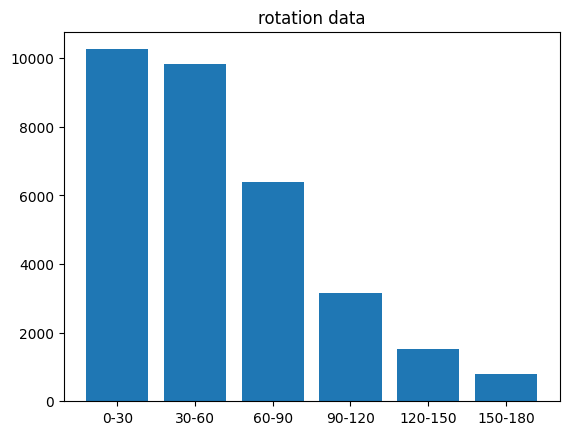

In [24]:
plt.title('rotation data')
plt.bar(x, y)
plt.show()

In [26]:
translation = pd.read_csv("/home/kmuvcl/source/oldCuTi/CuTi/logs/train_data_output/gt_translation_magnitude_vs_error.csv")

In [27]:
gt_tra = []
for i in range(len(translation['gt'])):
    gt_tra.append(translation['gt'][i])

In [32]:
x = ['0.0-0.5','0.5-1.0','1.0-1.5','1.5-2.0','2.0-2.5','2.5-3.0','3.0-3.5','else']
y = [0,0,0,0,0,0,0,0]

In [33]:
for i in range(len(gt_tra)):
    if gt_tra[i]>=0 and gt_tra[i]<0.5:
        y[0] += 1
    elif gt_tra[i]>=0.5 and gt_tra[i]<1.0:
        y[1] += 1
    elif gt_tra[i]>=1.0 and gt_tra[i]<1.5:
        y[2] += 1
    elif gt_tra[i]>=1.5 and gt_tra[i]<2.0:
        y[3] += 1
    elif gt_tra[i]>=2.0 and gt_tra[i]<2.5:
        y[4] += 1
    elif gt_tra[i]>=2.5 and gt_tra[i]<3.0:
        y[5] += 1
    elif gt_tra[i]>=3.0 and gt_tra[i]<3.5:
        y[6] += 1
    else:
        y[7] += 1
    

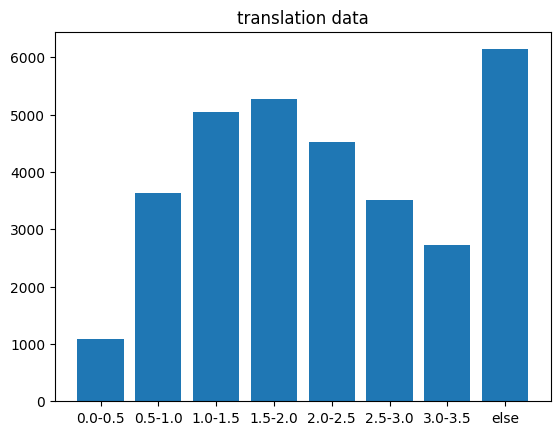

In [34]:
plt.title('translation data')
plt.bar(x,y)
plt.show()